In [175]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import sys
from adjustText import adjust_text  # https://github.com/Phlya/adjustText/wiki
sys.path.append('/home/beards/code/epic_calculations/epic_calculations')
import telescope_observation
reload(telescope_observation)  # Do this while I'm developing telescope_observation
from telescope_observation import TelescopeObservation

In [176]:
dsa_layout = np.loadtxt('/home/beards/code/epic_calculations/layouts/dsa_5m_15km.txt')
ovro_lwa_layout = np.loadtxt('/home/beards/code/epic_calculations/layouts/lwa_5km.txt')
ngvla_core_layout = np.loadtxt('/home/beards/code/epic_calculations/layouts/ngvla_core.txt')
ngvla_sba_layout = np.loadtxt('/home/beards/code/epic_calculations/layouts/ngvla_sba.txt')
ngvla_compact_layout = np.concatenate([ngvla_core_layout, ngvla_sba_layout], axis=0)
ska_low_layout = np.loadtxt('/home/beards/code/epic_calculations/layouts/ska_low.txt')
mwa_compact_layout = np.loadtxt('/home/beards/code/epic_calculations/layouts/mwa_phase2_compact.txt')
mwa_extended_layout = np.loadtxt('/home/beards/code/epic_calculations/layouts/mwa_phase2_extended.txt')
mwa_iii_layout = np.concatenate([mwa_compact_layout, mwa_extended_layout])
hera_layout = np.loadtxt('/home/beards/code/epic_calculations/layouts/HERA350.txt')

# Open questions
- What integration time to use?
- How many channels should we assume for each telescope?
- Grid size - use FoV at lowest end of band? Center of band?
- Pick center frequency for tunable arrays (MWA)
- HERA layout

In [251]:
# Set up all the TelescopeObservations
integration = .5e-3  # .5 ms
# May want sub-ms to resolve pulses

dsa = TelescopeObservation(layout=dsa_layout, Dant=5, f0=1.35e3, bandwidth=1.3e3,
                           df=0.024, integration=integration)
ovro = TelescopeObservation(layout=ovro_lwa_layout, Dant=3., f0=55, bandwidth=60.,
                            df=0.024, integration=integration)
ngvla = TelescopeObservation(layout=ngvla_compact_layout, Dant=18, f0=2.4e3, bandwidth=2.3e3,
                             df=2.3e3 / 64e3, integration=integration)
ska_low = TelescopeObservation(layout=ska_low_layout, Dant=35, f0=200, bandwidth=300.,
                               df=0.01, integration=integration)
ska_low_core = TelescopeObservation(layout=ska_low_layout, Darray=1e3, Dant=35, f0=200, bandwidth=300.,
                                    df=0.01, integration=integration)
ska_low_extreme_core = TelescopeObservation(Darray=1e3, Nant=131072. / 2., Dant=1., f0=200, bandwidth=300.,
                                            df=0.01, integration=integration)
mwa_ii_compact = TelescopeObservation(layout=mwa_compact_layout, Dant=4.5, f0=180., bandwidth=30.72,
                                      df=0.04, integration=integration)
# mwa_ii_extended = TelescopeObservation(layout=mwa_extended_layout, Dant=4.5, f0=180., bandwidth=30.72,
#                                        df=0.04, integration=integration)
mwa_iii = TelescopeObservation(layout=mwa_iii_layout, Dant=4.5, f0=180., bandwidth=30.72 * 2,
                                       df=0.01, integration=integration)
puma_petite = TelescopeObservation(Darray=600., Nant=5e3, Dant=6., f0=650, bandwidth=900.,
                                   df=.024, integration=integration)
puma_full = TelescopeObservation(Darray=1500., Nant=32e3, Dant=6., f0=650, bandwidth=900.,
                                 df=.024, integration=integration)
hera = TelescopeObservation(layout=hera_layout, Dant=14., f0=150., bandwidth=187., df=0.0305,
                            integration=integration)
hera_core = TelescopeObservation(layout=hera_layout, Dant=14., Darray=310., f0=150., bandwidth=187.,
                                 df=.0305, integration=integration)
# Make HERA III filled out to the outriggers
hera_iii = TelescopeObservation(Darray=hera.Darray, Nant=3000., Dant=14., f0=150., bandwidth=187.,
                                df=.0305, integration=integration)

In [284]:
obs_dict = {'DSA-2000': dsa, 'OVRO-LWA-2000': ovro, 'ngVLA': ngvla, 'SKA-Low': ska_low, 'SKA-Low Core': ska_low_core,
            'SKA-Low Extreme Core': ska_low_extreme_core, 'MWA-II Compact': mwa_ii_compact,
            'MWA-III': mwa_iii, 'PUMA Petite': puma_petite,
            'PUMA Full': puma_full, 'HERA': hera, 'HERA core': hera_core, 'HERA-III': hera_iii}
color_dict = {'DSA-2000': 'C0', 'OVRO-LWA-2000': 'C0', 'ngVLA': 'C0', 'SKA-Low': 'C0', 'SKA-Low Core': 'C1',
            'SKA-Low Extreme Core': 'C1', 'MWA-II Compact': 'C0',
            'MWA-III': 'C0', 'PUMA Petite': 'C1',
            'PUMA Full': 'C0', 'HERA': 'C0', 'HERA core': 'C1', 'HERA-III': 'C0'}
epic_flops = np.array([1e-9 * obs.vanilla_EPIC_stats(verbose=False) for obs in obs_dict.values()])
epic_out_bw = np.array([1e-9 * obs.img_out_bw for obs in obs_dict.values()])
fx_flops = np.array([1e-9 * obs.FX_stats(verbose=False) for obs in obs_dict.values()])
fx_out_bw = np.array([1e-9 * obs.vis_out_bw for obs in obs_dict.values()])
colors = [color_dict[tel] for tel in obs_dict.keys()]

<IPython.core.display.Javascript object>


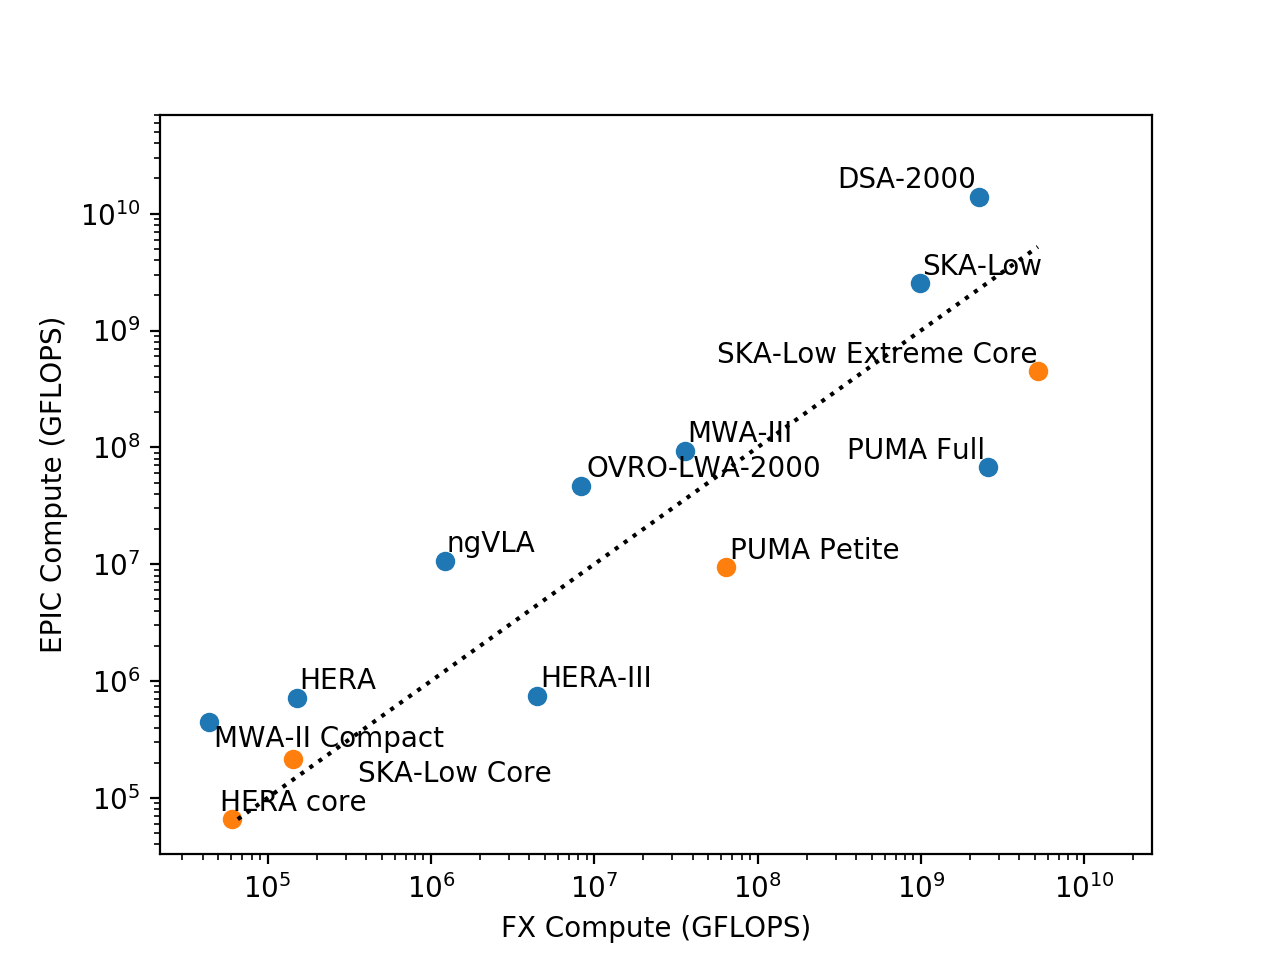

In [288]:
plt.figure()
[plt.loglog(fx, epic, 'o', mfc=color, mec=color) for fx, epic, color in zip(fx_flops, epic_flops, colors)]
# plt.loglog(fx_flops, epic_flops, 'o', mfc='k')
plt.plot([np.min(epic_flops), np.max(fx_flops)], [np.min(epic_flops), np.max(fx_flops)], ':k')
texts = [plt.text(x, y, label, ha='center', va='center') for label, x, y in zip(obs_dict.keys(), fx_flops, epic_flops)]
adjust_text(texts)

plt.xlabel('FX Compute (GFLOPS)')
plt.ylabel('EPIC Compute (GFLOPS)')
plt.xlim([.5 * fx_flops.min(), 5 * fx_flops.max()])
plt.ylim([.5 * epic_flops.min(), 5 * epic_flops.max()])

plt.savefig('/home/beards/temp/EPIC_Compute_Scaling.pdf')

<IPython.core.display.Javascript object>


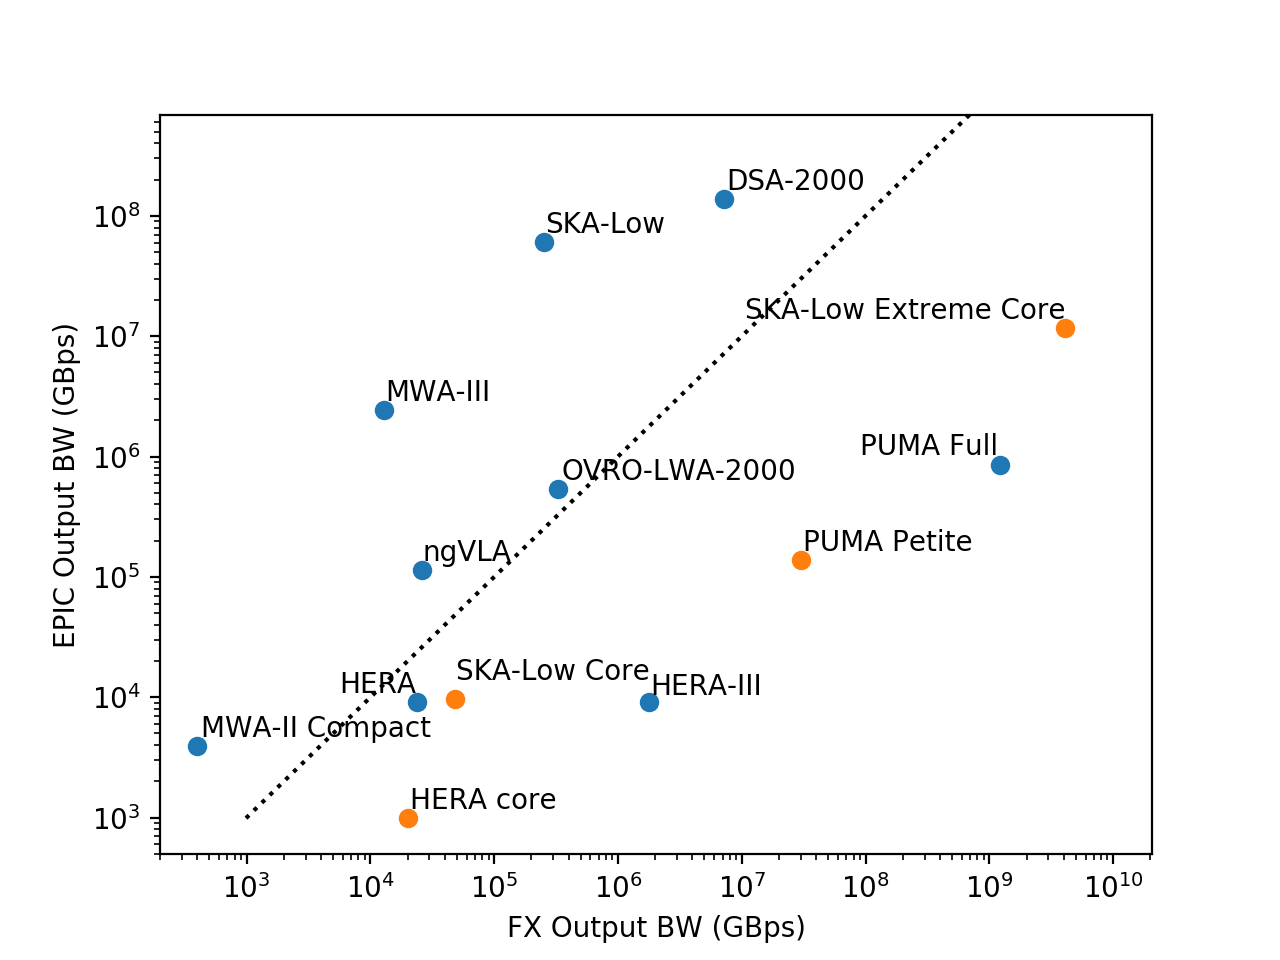

In [290]:
plt.figure()
[plt.loglog(fx, epic, 'o', mfc=color, mec=color) for fx, epic, color in zip(fx_out_bw, epic_out_bw, colors)]
plt.plot([np.min(epic_out_bw), np.max(fx_out_bw)], [np.min(epic_out_bw), np.max(fx_out_bw)], ':k')
texts = [plt.text(x, y, label, ha='center', va='center') for label, x, y in zip(obs_dict.keys(), fx_out_bw, epic_out_bw)]
adjust_text(texts)

plt.xlabel('FX Output BW (GBps)')
plt.ylabel('EPIC Output BW (GBps)')
plt.xlim([.5 * fx_out_bw.min(), 5 * fx_out_bw.max()])
plt.ylim([.5 * epic_out_bw.min(), 5 * epic_out_bw.max()])

plt.savefig('/home/beards/temp/EPIC_output_BW.pdf')


In [267]:

FX_cost = []
EPIC_cost = []
FX_low_cost = []
EPIC_low_cost = []

integrations = np.arange(1e-5, .5e-3, 1e-5)
for integration in integrations:
    temp = TelescopeObservation(layout=mwa_iii_layout, Dant=4.5, f0=180., bandwidth=30.72 * 2,
                                       df=0.01, integration=integration)

    FX_cost.append(temp.FX_stats(verbose=False))
    EPIC_cost.append(temp.vanilla_EPIC_stats(verbose=False))

<IPython.core.display.Javascript object>


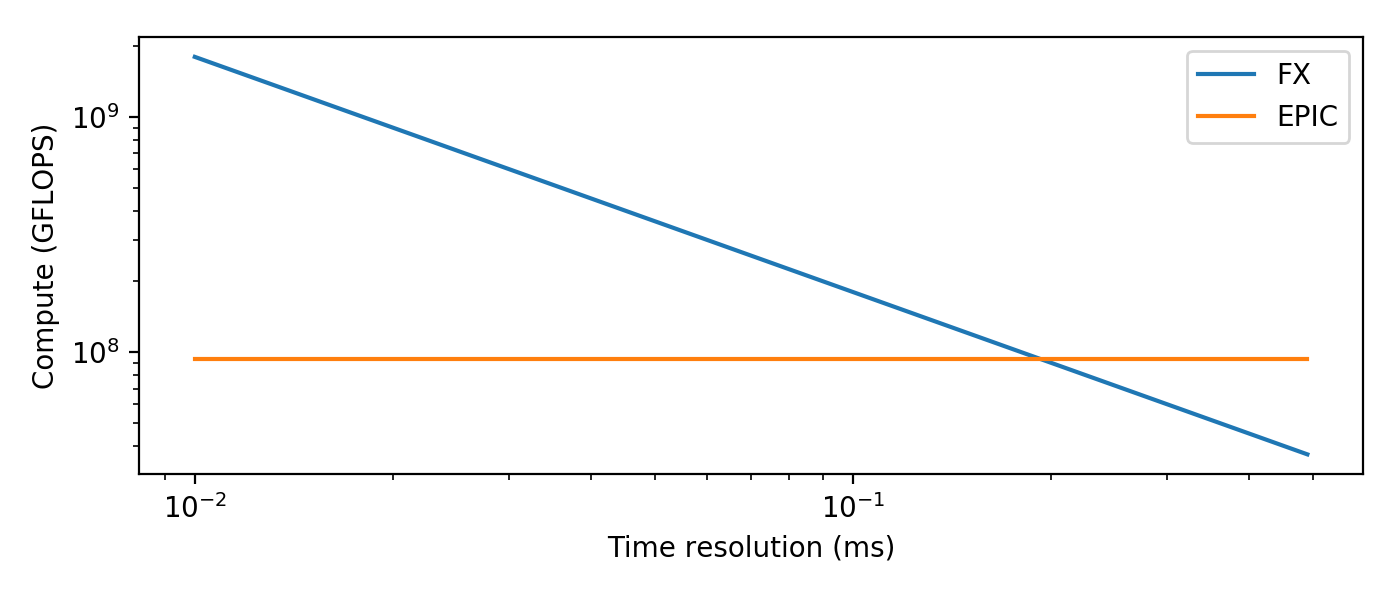

In [298]:
plt.figure(figsize=(7, 3))
plt.plot(integrations * 1e3, np.array(FX_cost) * 1e-9, label='FX')
plt.plot(integrations * 1e3, np.array(EPIC_cost) * 1e-9, label='EPIC')
# plt.plot(integrations, FX_low_cost, label='FX low')
# plt.plot(integrations, EPIC_low_cost, label='EPIC low')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('Time resolution (ms)')
plt.ylabel('Compute (GFLOPS)')

plt.tight_layout()
plt.savefig('/home/beards/temp/EPIC_changing_int.pdf')

# per channel analysis

In [157]:
# Set up all the TelescopeObservations
integration = 1e-3  # 1 ms
# May want sub-ms to resolve pulses

dsa = TelescopeObservation(layout=dsa_layout, Dant=5, f0=1.35e3, bandwidth=1,
                           df=1, integration=integration)
ovro = TelescopeObservation(layout=ovro_lwa_layout, Dant=1.5, f0=55, bandwidth=1.,
                            df=1, integration=integration)
ngvla = TelescopeObservation(layout=ngvla_compact_layout, Dant=18, f0=11.2e3, bandwidth=1,
                             df=1., integration=integration)
ngvla_low = TelescopeObservation(layout=ngvla_compact_layout, Dant=18, f0=2.4e3, bandwidth=1,
                             df=1., integration=integration)
ska_low = TelescopeObservation(layout=ska_low_layout, Dant=35, f0=200, bandwidth=1.,
                               df=1, integration=integration)
ska_low_core = TelescopeObservation(layout=ska_low_layout, Darray=1e3, Dant=35, f0=200, bandwidth=1.,
                                    df=1, integration=integration)
ska_low_extreme_core = TelescopeObservation(Darray=1e3, Nant=131072. / 2., Dant=1., f0=200, bandwidth=1.,
                                            df=1., integration=integration)
mwa_ii_compact = TelescopeObservation(layout=mwa_compact_layout, Dant=4.5, f0=200, bandwidth=1,
                                      df=1, integration=integration)
mwa_ii_extended = TelescopeObservation(layout=mwa_extended_layout, Dant=4.5, f0=200, bandwidth=1,
                                       df=1, integration=integration)
mwa_iii = TelescopeObservation(layout=mwa_iii_layout, Dant=4.5, f0=200, bandwidth=1,
                                       df=1, integration=integration)
puma_light = TelescopeObservation(Darray=600., Nant=5e3, Dant=6., f0=650, bandwidth=1.,
                                  df=1, integration=integration)
puma_full = TelescopeObservation(Darray=1500., Nant=32e3, Dant=6., f0=650, bandwidth=1.,
                                 df=1, integration=integration)
hera = TelescopeObservation(layout=hera_layout, Dant=14., f0=150., bandwidth=1., df=1,
                            integration=integration)
hera_core = TelescopeObservation(layout=hera_layout, Dant=14., Darray=310., f0=150., bandwidth=1.,
                                 df=1, integration=integration)

In [148]:
obs_dict = {'DSA-2000': dsa, 'OVRO-LWA-2000': ovro, 'NGVLA': ngvla, 'SKA-Low': ska_low, 'SKA-Low Core': ska_low_core,
            'SKA-Low Extreme Core': ska_low_extreme_core, 'MWA-II Compact': mwa_ii_compact,
            'MWA-II Extended': mwa_ii_extended, 'MWA-III': mwa_iii, 'PUMA light': puma_light,
            'PUMA Full': puma_full, 'HERA': hera, 'HERA core': hera_core, 'NGVLA_Low': ngvla_low}
epic_flops = np.array([1e-9 * obs.vanilla_EPIC_stats(verbose=False) for obs in obs_dict.values()])
epic_out_bw = np.array([1e-9 * obs.img_out_bw for obs in obs_dict.values()])
fx_flops = np.array([1e-9 * obs.FX_stats(verbose=False) for obs in obs_dict.values()])
fx_out_bw = np.array([1e-9 * obs.vis_out_bw for obs in obs_dict.values()])

<IPython.core.display.Javascript object>


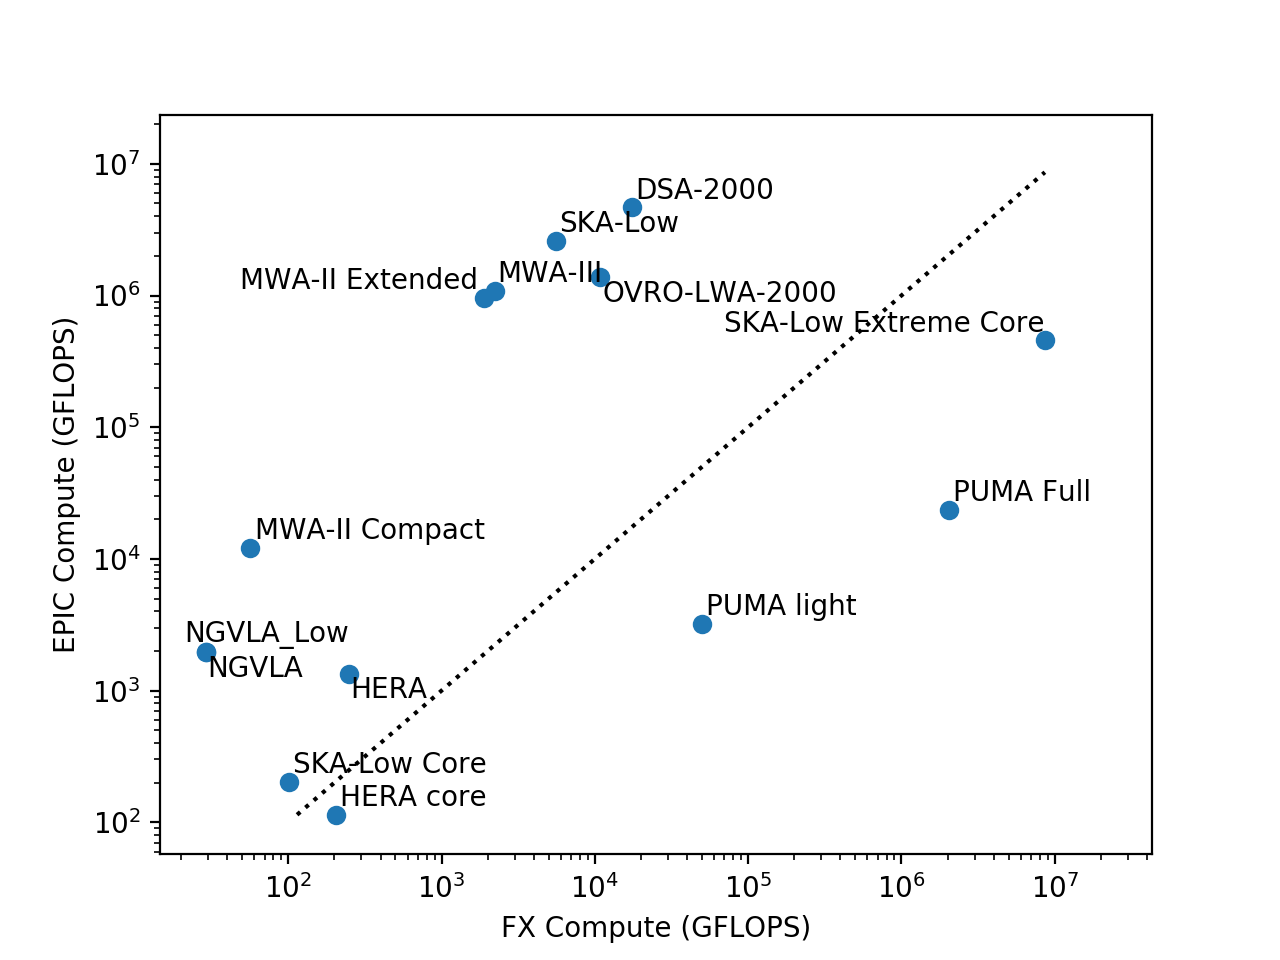

(57.037168290631264, 23393472.807477359)

In [149]:
plt.figure()
plt.loglog(fx_flops, epic_flops, 'o')
plt.plot([np.min(epic_flops), np.max(fx_flops)], [np.min(epic_flops), np.max(fx_flops)], ':k')
texts = [plt.text(x, y, label, ha='center', va='center') for label, x, y in zip(obs_dict.keys(), fx_flops, epic_flops)]
adjust_text(texts)

plt.xlabel('FX Compute (GFLOPS)')
plt.ylabel('EPIC Compute (GFLOPS)')
plt.xlim([.5 * fx_flops.min(), 5 * fx_flops.max()])
plt.ylim([.5 * epic_flops.min(), 5 * epic_flops.max()])

<IPython.core.display.Javascript object>


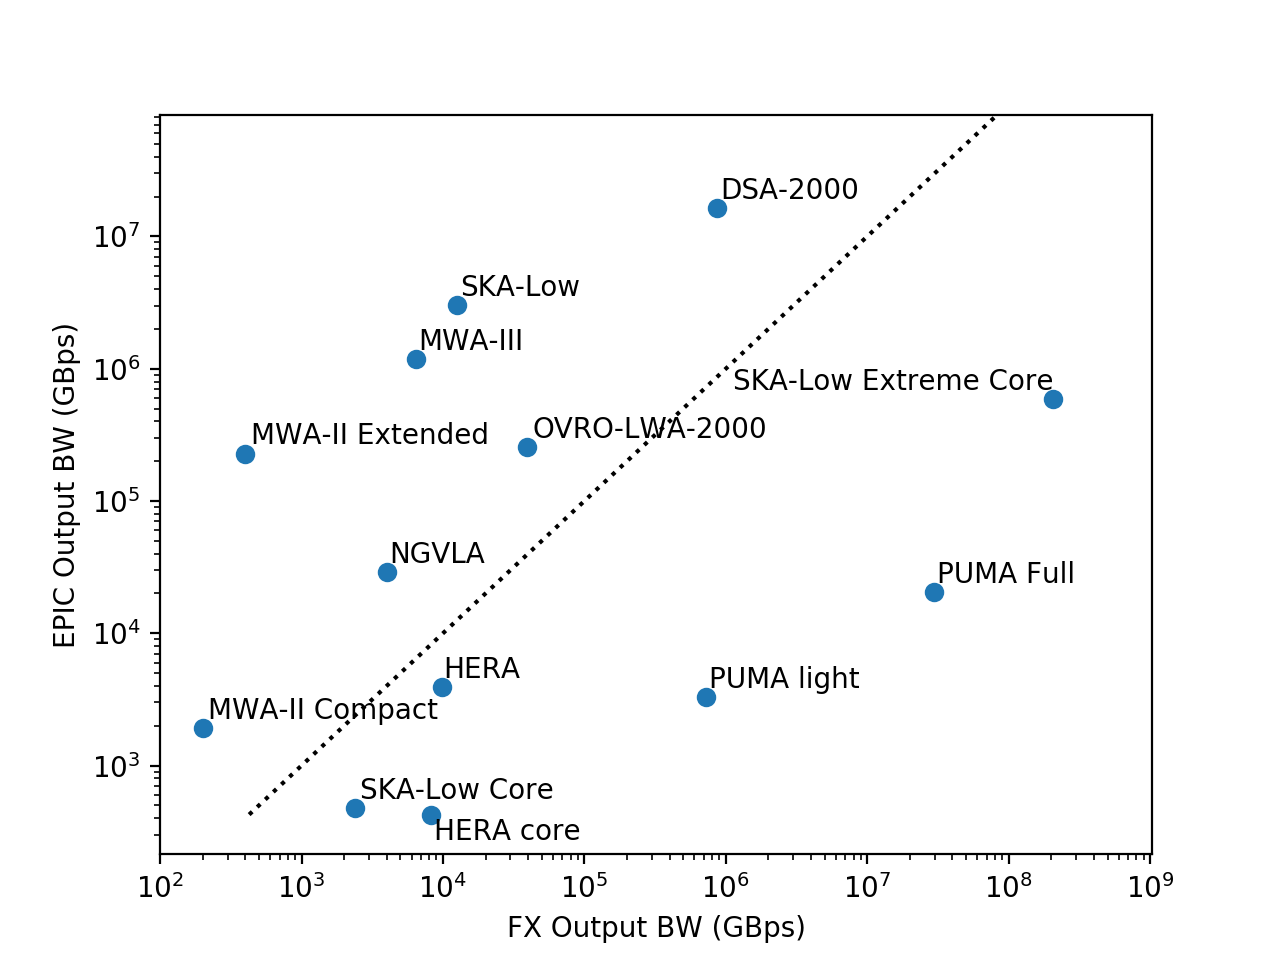

(213.16000000000003, 82396913.040000007)

In [92]:
plt.figure()
plt.loglog(fx_out_bw, epic_out_bw, 'o')
plt.plot([np.min(epic_out_bw), np.max(fx_out_bw)], [np.min(epic_out_bw), np.max(fx_out_bw)], ':k')
texts = [plt.text(x, y, label, ha='center', va='center') for label, x, y in zip(obs_dict.keys(), fx_out_bw, epic_out_bw)]
adjust_text(texts)

plt.xlabel('FX Output BW (GBps)')
plt.ylabel('EPIC Output BW (GBps)')
plt.xlim([.5 * fx_out_bw.min(), 5 * fx_out_bw.max()])
plt.ylim([.5 * epic_out_bw.min(), 5 * epic_out_bw.max()])

# Run version for cosmology

In [9]:
# Set up all the TelescopeObservations
integrations = {'DSA-2000': 2, 'OVRO-LWA-2000': 2, 'NGVLA': 2, 'SKA-Low': 2, 'SKA-Low Core': 2,
            'SKA-Low Extreme Core': 2, 'MWA-II Compact': 2,
            'MWA-II Extended': .5, 'MWA-III': .5, 'PUMA light': 2,
            'PUMA Full': .5, 'HERA': 2, 'HERA core': 5}
for key in obs_dict.keys():
    obs_dict[key].integration = integrations[key]
    obs_dict[key]._set_dependents()

In [10]:
obs_dict = {'DSA-2000': dsa, 'OVRO-LWA-2000': ovro, 'NGVLA': ngvla, 'SKA-Low': ska_low, 'SKA-Low Core': ska_low_core,
            'SKA-Low Extreme Core': ska_low_extreme_core, 'MWA-II Compact': mwa_ii_compact,
            'MWA-II Extended': mwa_ii_extended, 'MWA-III': mwa_iii, 'PUMA light': puma_light,
            'PUMA Full': puma_full, 'HERA': hera, 'HERA core': hera_core}
epic_flops = np.array([1e-9 * obs.vanilla_EPIC_stats(verbose=False) for obs in obs_dict.values()])
fx_flops = np.array([1e-9 * obs.FX_stats(verbose=False) for obs in obs_dict.values()])

<IPython.core.display.Javascript object>


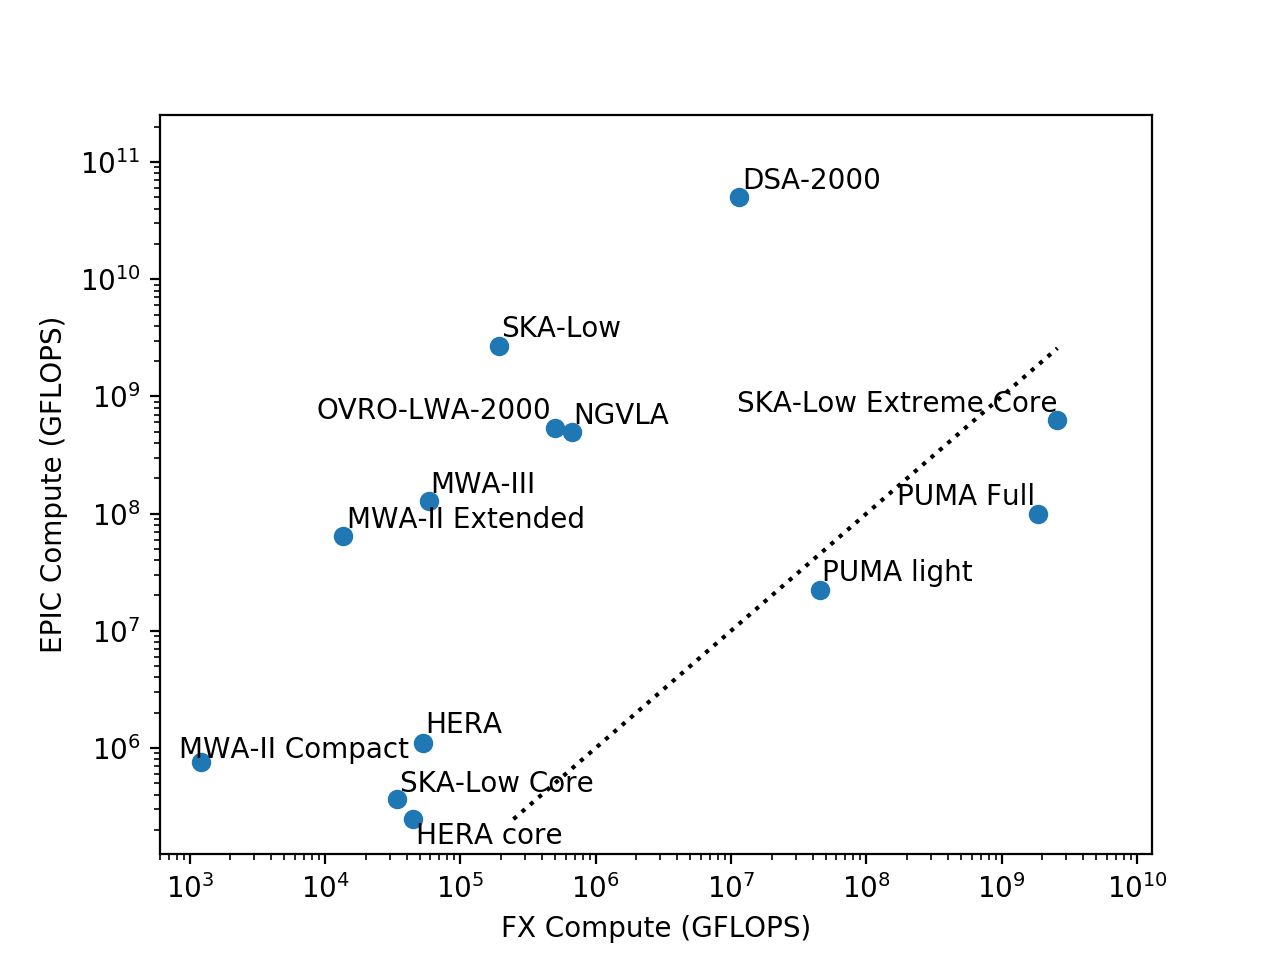

(123281.11925556067, 251256523747.07959)

In [11]:
plt.figure()
plt.loglog(fx_flops, epic_flops, 'o')
plt.plot([np.min(epic_flops), np.max(fx_flops)], [np.min(epic_flops), np.max(fx_flops)], ':k')
texts = [plt.text(x, y, label, ha='center', va='center') for label, x, y in zip(obs_dict.keys(), fx_flops, epic_flops)]
adjust_text(texts)

plt.xlabel('FX Compute (GFLOPS)')
plt.ylabel('EPIC Compute (GFLOPS)')
plt.xlim([.5 * fx_flops.min(), 5 * fx_flops.max()])
plt.ylim([.5 * epic_flops.min(), 5 * epic_flops.max()])